<a href="https://colab.research.google.com/github/anothergrind/music_while_reading/blob/main/CGS_3346_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import modules for the project
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# Data Cleaning/Conditioning

# Read in the survey data from the class
df_survey = pd.read_csv(r'survey.csv')

# Survey dataframes for no music and music
df_no_music = df_survey[df_survey['Music'] == 'N']
df_music = df_survey[df_survey['Music'] == 'Y']

# Impute missing values for Opinion and Hungriness
def impute_opinion_demographics(df, demo_cols):
    df = df.copy()
    for name, group in df.groupby('Name'):
        missing_idx = group[group['Opinion'].isna()].index
        for idx in missing_idx:
            row = df.loc[idx]
            # Filter all other students in same condition (Music)
            candidates = df[
                (df['Music'] == row['Music']) &
                (df['Name'] != row['Name'])
            ]
            # Further filter by demographics
            for col in demo_cols:
                candidates = candidates[candidates[col] == row[col]]

            # Use observed Opinion values
            observed_op = candidates['Opinion'].dropna()
            if len(observed_op) > 0:
                df.loc[idx, 'Opinion'] = np.random.choice(observed_op)
            else:
                # Fallback: sample from all in same Music condition
                observed_op = df[df['Music'] == row['Music']]['Opinion'].dropna()
                df.loc[idx, 'Opinion'] = np.random.choice(observed_op)

            # Use observed Hungriness values
            observed_h = candidates['Hungriness'].dropna()
            if len(observed_h) > 0:
                df.loc[idx, 'Hungriness'] = np.random.choice(observed_h)
            else:
                observed_h = df[df['Music'] == row['Music']]['Hungriness'].dropna()
                df.loc[idx, 'Hungriness'] = np.random.choice(observed_h)

    return df

In [4]:
cols = ['Age', 'Gender', 'Major', 'Year']
df_survey_imp = impute_opinion_demographics(df_survey, cols)
df_survey_imp

,Name,Age,Gender,Major,Year,Hungriness,Music,Opinion
0,Nicholas,19,M,Y,Junior,6.0,N,4.0
1,Nicholas,19,M,Y,Junior,3.0,Y,4.0
2,Selugi,20,F,Y,Junior,4.0,N,6.0
3,Selugi,20,F,Y,Junior,6.0,Y,1.0
4,Aditi,19,F,Y,Sophomore,4.0,N,3.0
5,Aditi,19,F,Y,Sophomore,6.0,Y,1.0
6,Madhu,19,F,Y,Sophomore,7.0,N,2.0
7,Madhu,19,F,Y,Sophomore,6.0,Y,1.0
8,Karen,24,F,Y,Junior,2.0,N,4.0
9,Karen,24,F,Y,Junior,7.0,Y,4.0


In [5]:
# Matched Pairs T-Test

# Convert the dataframe to wide format
df_wide = df_survey_imp.pivot(index = 'Name', columns = 'Music', values = 'Opinion').reset_index()
df_wide.rename(columns={'N':'Opinion_no', 'Y':'Opinion_yes'}, inplace=True)

# Calculate the differences with and without music
df_wide['D'] = df_wide['Opinion_yes'] - df_wide['Opinion_no']

# Display the differences in opinion
print(df_wide[['Name','Opinion_no','Opinion_yes','D']])

# Run a paired t-test
t_stat, p_value = ttest_rel(df_wide['Opinion_yes'], df_wide['Opinion_no'])
print(f"Paired t-test results:\nt = {t_stat:.3f}, p = {p_value:.3f}")

# Determine statistical significance
if p_value < 0.05:
    print("Significant difference in opinions with vs. without music (reject H0)")
else:
    print("No significant difference in opinions (fail to reject H0)")

Music      Name  Opinion_no  Opinion_yes    D
0         Aditi         3.0          1.0 -2.0
1         Danat         4.0          1.0 -3.0
2         Darsh         7.0          5.0 -2.0
3         Karen         4.0          4.0  0.0
4         Leina         4.0          4.0  0.0
5         Madhu         2.0          1.0 -1.0
6       Mridini         1.0          1.0  0.0
7      Nicholas         4.0          4.0  0.0
8       Rebecca         2.0          1.0 -1.0
9         Reham         4.0          1.0 -3.0
10       Sakshi         4.0          1.0 -3.0
11       Selugi         6.0          1.0 -5.0
12        Vipha         2.0          1.0 -1.0
13         Zora         6.0          1.0 -5.0
Paired t-test results:
t = -3.976, p = 0.002
Significant difference in opinions with vs. without music (reject H0)


In [6]:
# Create a mixed effects model
df_mixed = df_survey_imp.copy()

# Convert columns to binary and dummy encode
df_mixed["Music"] = df_mixed["Music"].map({"N":0,"Y":1})
df_mixed["Gender"] = df_mixed["Gender"].map({"M":0,"F":1})
df_mixed["Major"] = df_mixed["Major"].map({"N":0,"Y":1})
df_mixed = pd.get_dummies(df_mixed, columns=["Year"], drop_first=True)

# Drop the name and age columns
df_mixed = df_mixed.drop(['Age'], axis=1)

model = smf.mixedlm(
    "Opinion ~ Music + Gender + Major + Hungriness + Year_Sophomore + Year_Senior",
    df_mixed,
    groups=df_mixed["Name"]  # keep Name here!
)
result = model.fit()
print(result.summary())

              Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    Opinion 
No. Observations:      28         Method:                REML    
No. Groups:            14         Scale:                 1.6184  
Min. group size:       2          Log-Likelihood:        -43.5490
Max. group size:       2          Converged:             Yes     
Mean group size:       2.0                                       
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               7.533    1.539  4.894 0.000  4.516 10.550
Year_Sophomore[T.True] -0.490    0.681 -0.719 0.472 -1.825  0.845
Year_Senior[T.True]     0.292    0.718  0.407 0.684 -1.115  1.700
Music                  -1.574    0.515 -3.058 0.002 -2.582 -0.565
Gender                 -2.484    0.837 -2.968 0.003 -4.124 -0.844
Major                  -

In [7]:
# Bootstrap (Opinion)
print("Hello World")

res_boot_sim = []
B = 2000
N = len(df_survey)
for i in range(B):
  boot_df = df_survey.sample(N, replace=True)
  M = np.mean(boot_df['Opinion'])
  res_boot_sim.append(M)

LL_b = np.quantile(res_boot_sim, 0.025)
UL_b = np.quantile(res_boot_sim, 0.975)

print("LL_b = " , LL_b)
print("UL_b = ", UL_b)

Hello World
LL_b =  2.7390732265446225
UL_b =  4.411996904024766


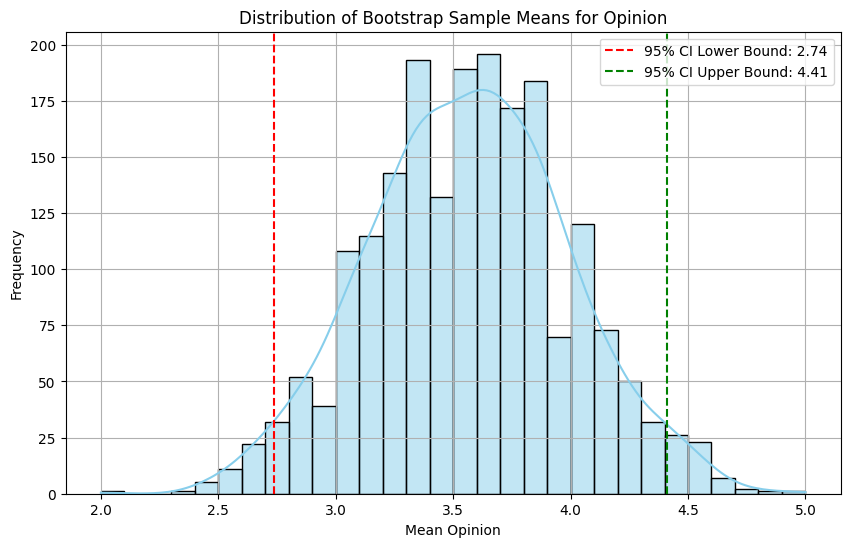

In [8]:
# Confidence Interval (95%, Opinion)
plt.figure(figsize=(10, 6))
sns.histplot(res_boot_sim, kde=True, color='skyblue', bins=30)
plt.axvline(LL_b, color='red', linestyle='--', label=f'95% CI Lower Bound: {LL_b:.2f}')
plt.axvline(UL_b, color='green', linestyle='--', label=f'95% CI Upper Bound: {UL_b:.2f}')
plt.title('Distribution of Bootstrap Sample Means for Opinion')
plt.xlabel('Mean Opinion')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Bootstrap (Hungriness)
print("Hello World")

hunger = []
B = 2000
N = len(df_survey)
for i in range(B):
  boot_df = df_survey.sample(N, replace=True)
  M = np.mean(boot_df['Hungriness'])
  hunger.append(M)

LL_b = np.quantile(hunger, 0.025)
UL_b = np.quantile(hunger, 0.975)

print("LL_b = " , LL_b)
print("UL_b = ", UL_b)

Hello World
LL_b =  4.222222222222222
UL_b =  5.75


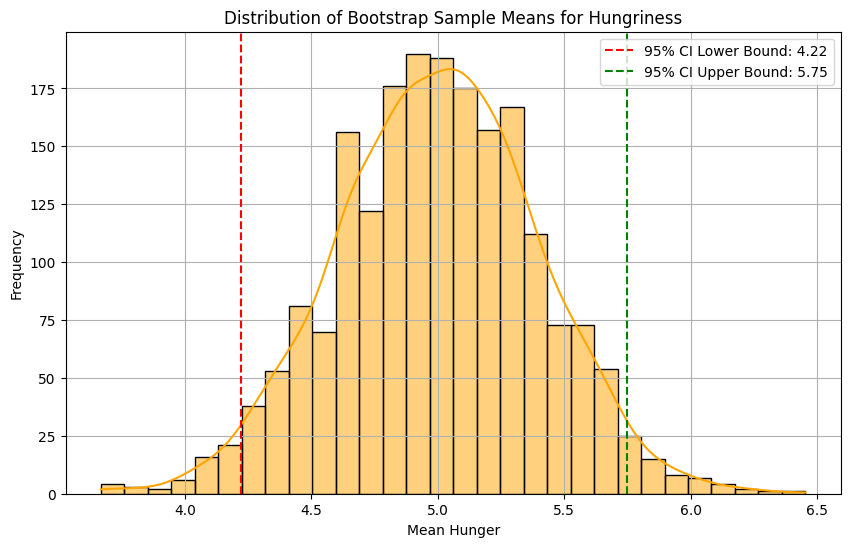

In [10]:
# Confidence Interval (95%, Hunger)
plt.figure(figsize=(10, 6))
sns.histplot(hunger, kde=True, color='orange', bins=30)
plt.axvline(LL_b, color='red', linestyle='--', label=f'95% CI Lower Bound: {LL_b:.2f}')
plt.axvline(UL_b, color='green', linestyle='--', label=f'95% CI Upper Bound: {UL_b:.2f}')
plt.title('Distribution of Bootstrap Sample Means for Hungriness')
plt.xlabel('Mean Hunger')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
paired_t_test = []
B = 2000
N = len(df_wide)

for i in range(B):
  sample = df_wide['D'].sample(N, replace=True)
  M_D = np.mean(sample)
  paired_t_test.append(M_D)

LL_D = np.quantile(paired_t_test, 0.025)
UL_D = np.quantile(paired_t_test, 0.975)

print(f"95% Confidence Interval for Mean Difference (D):\nLower Bound (LL_D) = {LL_D:.2f}\nUpper Bound (UL_D) = {UL_D:.2f}")

95% Confidence Interval for Mean Difference (D):
Lower Bound (LL_D) = -2.71
Upper Bound (UL_D) = -1.00


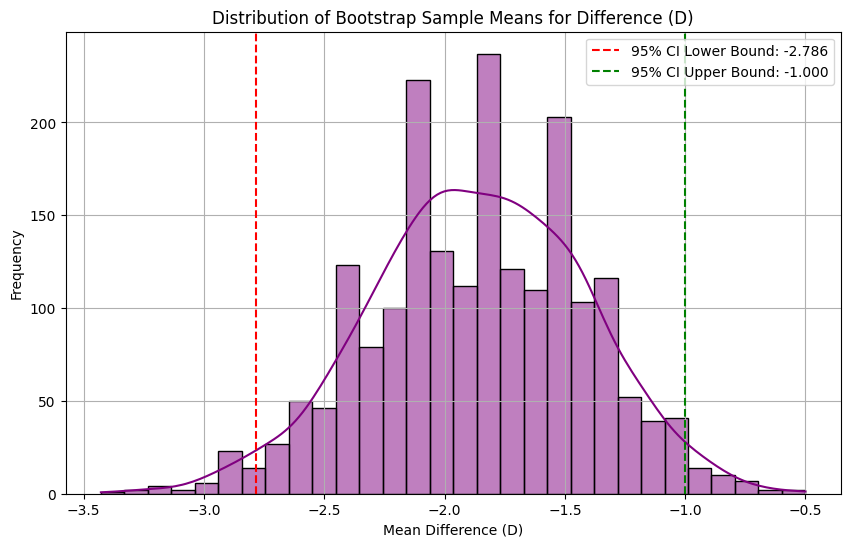

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(paired_t_test, kde=True, color='purple', bins=30)
plt.axvline(LL_D, color='red', linestyle='--', label=f'95% CI Lower Bound: {LL_D:.3f}')
plt.axvline(UL_D, color='green', linestyle='--', label=f'95% CI Upper Bound: {UL_D:.3f}')
plt.title('Distribution of Bootstrap Sample Means for Difference (D)')
plt.xlabel('Mean Difference (D)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()